In [1]:
import os
import pickle
import pandas as pd
import numpy as np
from collections import OrderedDict
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

## 1. Load Dataset 

In [2]:
X_train = pd.read_csv('./label_syn/encoding_train_eng.csv', encoding='utf-8-sig')
X_valid = pd.read_csv('./label_syn/encoding_valid_eng.csv', encoding='utf-8-sig')

In [3]:
y_train= pd.read_csv('./label_syn/y_train_eng.csv', encoding='utf-8-sig')
y_valid= pd.read_csv('./label_syn/y_valid_eng.csv', encoding='utf-8-sig')

## 1_2. Load Dataset  & Reflect Feature Importance

In [6]:
X_train.columns

Index(['Office ID', 'Process Type', 'Import Type', 'Import Use',
       'Payment Type', 'Mode of Transport', 'Declarant ID', 'Importer ID',
       'Seller ID', 'Courier ID', 'HS10 Code', 'Country of Departure',
       'Country of Origin', 'Tax Rate', 'Tax Type',
       'Country of Origin Indicator', 'Net Mass', 'Item Price'],
      dtype='object')

## 2. Over sampling

In [8]:
from imblearn.over_sampling import RandomOverSampler

In [10]:
over_sampler = RandomOverSampler(random_state = 11)
X_train_over,y_train_over = over_sampler.fit_resample(X_train,y_train)

In [11]:
over_sampler = RandomOverSampler(random_state = 11)
X_valid_over,y_valid_over = over_sampler.fit_resample(X_valid,y_valid)

## 3. Select xgboost Parameter

In [13]:
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier

In [14]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [15]:
from scipy import stats
from scipy.stats import randint

In [22]:
xgb = XGBClassifier()#objective=' binary:logistic',
                    #metric='binary',
                    #eval_metric='logloss',
                    #nthread=1)

# A parameter grid for XGBoost
params = {'n_estimators': stats.randint(150, 1000),
          'learning_rate': stats.uniform(0.01, 0.6),
          'min_child_weight': [1, 2, 3, 4, 5],
          'gamma': [0.5, 1, 1.5, 2, 5],
          'subsample': [0.6, 0.8, 1.0],
          'colsample_bytree': [0.6, 0.8, 1.0],
          'max_depth': [3, 4, 5]
        }
folds = 3

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb,
                                   param_distributions=params,
                                   n_iter=5, # you want 5 here not 25 if I understand you correctly 
                                   scoring='roc_auc',
                                   n_jobs=1,                                   
                                   cv=skf.split(X_train_over, y_train_over),
                                   verbose=3,
                                   random_state=1001 )

# Here we go
start_time = timer(None) 
random_search.fit(X_train_over, y_train_over)
timer(start_time) 

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] colsample_bytree=0.8, gamma=1, learning_rate=0.16903813936450346, max_depth=5, min_child_weight=4, n_estimators=420, subsample=0.8 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[20:10:12] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.8, gamma=1, learning_rate=0.16903813936450346, max_depth=5, min_child_weight=4, n_estimators=420, subsample=0.8, score=0.892, total= 2.0min
[CV] colsample_bytree=0.8, gamma=1, learning_rate=0.16903813936450346, max_depth=5, min_child_weight=4, n_estimators=420, subsample=0.8 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.0min remaining:    0.0s


[20:12:09] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.8, gamma=1, learning_rate=0.16903813936450346, max_depth=5, min_child_weight=4, n_estimators=420, subsample=0.8, score=0.887, total= 1.7min
[CV] colsample_bytree=0.8, gamma=1, learning_rate=0.16903813936450346, max_depth=5, min_child_weight=4, n_estimators=420, subsample=0.8 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.6min remaining:    0.0s


[20:13:49] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.8, gamma=1, learning_rate=0.16903813936450346, max_depth=5, min_child_weight=4, n_estimators=420, subsample=0.8, score=0.884, total= 1.8min
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.14394521160744317, max_depth=5, min_child_weight=5, n_estimators=398, subsample=0.6 
[20:15:39] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.14394521160744317, max_depth=5, min_child_weight=5, n_estimators=398, subsample=0.6, score=0.843, total= 1.9min
[CV] colsample_bytree=0.6, ga

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 19.4min finished



 Time taken: 0 hours 20 minutes and 11.96 seconds.


In [23]:
# print('\n All results:')
# print(random_search.cv_results_)
# print('\n Best estimator:')
# print(random_search.best_estimator_)
# param_comb = 5
# print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
# print(random_search.best_score_ * 2 - 1)
# print('\n Best hyperparameters:')
# print(random_search.best_params_)
# results = pd.DataFrame(random_search.cv_results_)
# results.to_csv('./data1/xgb-random-grid-search-results-01.csv', index=False)

## 4. Train model

In [24]:
from sklearn.metrics import confusion_matrix,precision_score,accuracy_score,recall_score,f1_score,roc_auc_score

def get_clf_eval2(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred, average ='macro')
    recall = recall_score(y_test, pred, average ='macro')
    f1 = f1_score(y_test, pred, average ='macro')
    
    print("confusion\n", confusion)
    print("Accuracy: {0:.4f}, precision: {1:.4f}, recall: {2:.4f}, F1:{3:.4f}\n".format(accuracy, precision, recall, f1))
    
def get_model_train_eval2(model, ftr_train = None, ftr_test = None, tgt_train = None, tgt_test = None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:, 1]
    get_clf_eval2(tgt_test, pred, pred_proba)

In [25]:
xgb_model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.5994130001745845, max_delta_step=0, max_depth=4,
              min_child_weight=2, monotone_constraints='()',
              n_estimators=424, n_jobs=20, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1.0,
              tree_method='exact', validate_parameters=1, verbosity=None, objective= 'binary:logistic', eval_metric='logloss')

In [26]:
start_time = timer(None) 
get_model_train_eval2(xgb_model, ftr_train = X_train_over, ftr_test = X_valid_over, 
                      tgt_train = y_train_over, tgt_test = y_valid_over)
timer(start_time) 

confusion
 [[5527 1130]
 [3148 3509]]
Accuracy: 0.6787, precision: 0.6968, recall: 0.6787, F1:0.6711


 Time taken: 0 hours 0 minutes and 2.17 seconds.


## 5. Save model

In [30]:
import pickle
file_name = "./model_syn/xgb_reg_eng.pkl"

# save
pickle.dump(xgb_model, open(file_name, "wb"))

# load
new_xgb_model = pickle.load(open(file_name, "rb"))

### 3.2 Predict with xgboost model

In [32]:
file_name = "./model_syn/xgb_reg_eng.pkl"

# load
w_xgb_model = pickle.load(open(file_name, "rb"))

In [33]:
w_preds = w_xgb_model.predict(X_valid_over)
w_pred_proba = w_xgb_model.predict_proba(X_valid_over)[:,1]

In [34]:
get_clf_eval2(y_valid_over, w_preds, w_pred_proba)

confusion
 [[5527 1130]
 [3148 3509]]
Accuracy: 0.6787, precision: 0.6968, recall: 0.6787, F1:0.6711



## 6. Feature Importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

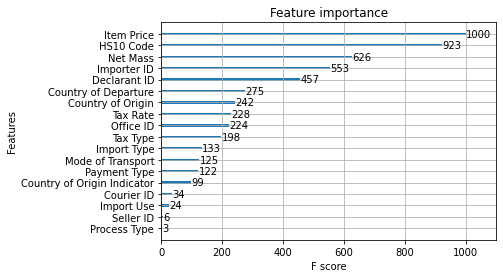

In [35]:
%matplotlib inline
from xgboost import plot_importance

plot_importance(xgb_model, max_num_features=20)

In [37]:
import eli5 
from eli5.sklearn import PermutationImportance 
perm = PermutationImportance(xgb_model, scoring = "accuracy", random_state = 22).fit(X_valid_over, y_valid_over) 
eli5.show_weights(perm, top = 20, feature_names = X_valid_over.columns.tolist())

Weight,Feature
0.0872 ± 0.0048,Item Price
0.0679 ± 0.0064,HS10 Code
0.0647 ± 0.0034,Net Mass
0.0295 ± 0.0044,Tax Rate
0.0252 ± 0.0046,Tax Type
0.0215 ± 0.0050,Country of Departure
0.0208 ± 0.0020,Country of Origin
0.0042 ± 0.0039,Declarant ID
0.0016 ± 0.0030,Importer ID
0.0015 ± 0.0030,Mode of Transport


## 6. Compare Prediction & Ground Truth

In [38]:
X_org = pd.read_csv('./label_syn/df_enc_valid_eng.csv', encoding='utf-8-sig')

In [41]:
pred_critical = w_xgb_model.predict(X_valid)

In [42]:
a = np.array([pred_critical])
pred_df = pd.DataFrame({'Fraud_Prediction':a[0]})
pred_df

,Fraud_Prediction
0,0
1,0
2,0
3,0
4,0
...,...
8475,0
8476,1
8477,0
8478,0


In [43]:
sample=X_org[['Office ID','Declarant ID','Importer ID','HS10 Code','Fraud']]

In [44]:
dfa = pd.DataFrame(sample)
final_df = dfa.join(pred_df)
final_df

,Office ID,Declarant ID,Importer ID,HS10 Code,Fraud,Fraud_Prediction
0,13,L77JJEG,HQ0W7JA,8407210000,0,0
1,20,749ECRU,Y2FJ95S,8479909070,0,0
2,19,OZB7KED,446O4EE,6211111000,0,0
3,31,SM89FYN,OOWNJY9,8207191000,1,0
4,20,DM8H44I,MU3B4MR,3304999000,0,0
...,...,...,...,...,...,...
8475,39,6D4DNS7,8TW53B3,6907210000,0,0
8476,40,3BTA0QN,USP5TV1,4911100000,1,1
8477,13,NULLLLS,XE08QFH,8530900000,1,0
8478,41,KWSE1HX,JUJJ961,1207400000,0,0


In [45]:
final_df.to_csv('./label_syn/predict_evaluation_eng.csv', index=None, encoding='949')